In [1]:
import pandas
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from datetime import datetime
from shapely.geometry import LineString
from shapely import wkt
import folium

plt.rcParams["axes.labelsize"] = 14

# U for Uber, T for T4c
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")

CITY = "london"
YEAR = 2019
MONTH = 10
START_DAY=21
END_DAY=27 # incl.

DAYTIME_START_HOUR = 8
DAYTIME_END_HOUR = 18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction'
]

In [3]:
simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']

# Load Uber data

In [4]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f'movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet')
uspeeds_df = uspeeds_df[(uspeeds_df["day"]>=START_DAY)&(uspeeds_df["day"]<=END_DAY)]
uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={'osm_start_node_id': 'u', 'osm_end_node_id': 'v', "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [ f"{u}_{v}_{osmid}" for u,v,osmid in zip(uspeeds_df["u"],uspeeds_df["v"],uspeeds_df["osmid"])]
uspeeds_df.shape

(10635026, 11)

# Load IARAI speed between 2019-10-21 and 2019-10-27

In [5]:
tspeeds_l = []
for i in range(START_DAY,END_DAY+1):
    f = TBASEPATH / 'speed_classes' / CITY / f'speed_classes_{YEAR}-{MONTH}-{i}.parquet'
    print(f)
    df = pd.read_parquet(f)
    df["date"]=df["day"]
    df["year"]= YEAR
    df["month"]= MONTH
    df["day"]=i
    df["hour"]= df["t"]//4
    df = df[['u', 'v', 'gkey','year', 'month',
            'day', 'hour', 'volume', 'volume_class', 'median_speed_kph', 
            'free_flow_kph', 'std_speed_kph']].groupby(
    by=['u', 'v', 'gkey','year', 'month', 'day','hour']).agg(
        volume_class=("volume_class", "mean"),
        volume=("volume", "mean"),
        std_speed_kph=("std_speed_kph", "mean"),
        median_speed_kph=("median_speed_kph", "mean"),
        free_flow_kph=("free_flow_kph", "first")
    ).reset_index()
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
tspeeds_df.shape


/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-21.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-22.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-23.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-24.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-25.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-26.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/london/speed_classes_2019-10-27.parquet


(12004258, 12)

In [6]:
gdf_nodes = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
gdf_edges = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")

In [7]:
gdf_edges = gdf_edges.merge(gdf_nodes, 
                            left_on="u", 
                            right_on="node_id", 
                            suffixes=["","_u"]).merge(gdf_nodes, 
                                                     left_on="v", 
                                                     right_on="node_id", 
                                                     suffixes=["","_v"])
gdf_edges.rename(columns={"x":"x_u", "y":"y_u"}, inplace=True)
del gdf_edges["geometry_u"]
del gdf_edges["geometry_v"]
gdf_edges.shape

(234308, 19)

In [8]:
# London bounding box
y_min,y_max,x_min,x_max = 51.20500, 51.70000, -0.36900, 0.06700

def in_bb(x,y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

# in the spatial coverage, within London is defined as either u or v is within the bounding box

gdf_edges["in_bb"] = [(in_bb(x_u,y_u) or in_bb(x_v,y_v)) for x_u,y_u,x_v,y_v 
                                in zip(gdf_edges["x_u"], gdf_edges["y_u"],
                                        gdf_edges["x_v"], gdf_edges["y_v"])]

In [9]:
gdf_edges[gdf_edges["in_bb"]==True].groupby('highway').size()

highway
construction          1
living_street        53
motorway            311
motorway_link       125
primary           33917
primary_link        511
residential       37277
road                  2
secondary         14738
secondary_link       88
service              19
tertiary          28749
tertiary_link       134
trunk             11928
trunk_link          779
unclassified       7506
dtype: int64

In [10]:
gdf_edges = gdf_edges[gdf_edges["in_bb"]==True]

In [11]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=['u', 'v', 'gkey','year', 
                                    'month','day', 'hour']).merge(gdf_edges, on=["u","v","gkey"])
ut_merged.head()

,u,v,osmid_x,year,month,day,hour,speed_mph_mean,speed_mph_stddev,speed_kph_mean,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,1343922650,108500,8179128,2019,10,21,12,11.078,1.550,17.828269,...,5.820857,"LINESTRING (-0.11501 51.53410, -0.11499 51.534...",Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
1,1343922650,108500,8179128,2019,10,21,9,9.261,4.482,14.904098,...,5.820857,"LINESTRING (-0.11501 51.53410, -0.11499 51.534...",Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
2,1343922650,108500,8179128,2019,10,25,16,10.145,3.661,16.326754,...,5.820857,"LINESTRING (-0.11501 51.53410, -0.11499 51.534...",Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
3,1343922650,108500,8179128,2019,10,25,18,8.334,2.892,13.412240,...,5.820857,"LINESTRING (-0.11501 51.53410, -0.11499 51.534...",Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True
4,1343922650,108500,8179128,2019,10,26,17,10.440,3.482,16.801510,...,5.820857,"LINESTRING (-0.11501 51.53410, -0.11499 51.534...",Wynford Road,1343922650,-0.115013,51.534101,108500,-0.114964,51.534082,True


In [12]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"]-ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")

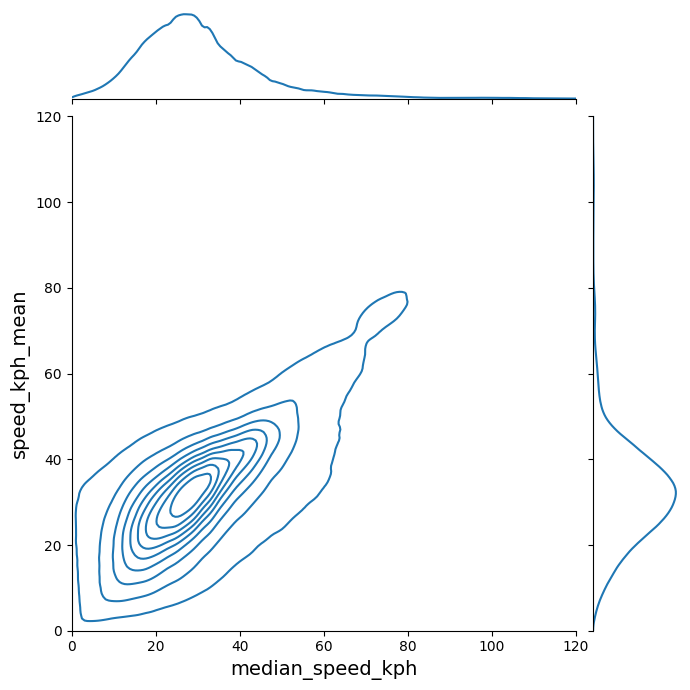

In [13]:
g = sns.jointplot(x="median_speed_kph", y="speed_kph_mean", data=ut_merged,
                  kind="kde", 
                  xlim=(0, 120), ylim=(0, 120),
                  height=7,
                  palette=sns.color_palette('Set2'))

# Stats of road segment matching  

In [14]:
def osm_color_palette():
    for c in ["#115f9a", "#22a7f0", 
                "#991f17", "#df8879", 
                "#48446e", "#9080ff", 
                "#a57c1b", "#ffb400"] + ["white"] * 99:
        yield c

In [15]:
# time label
ut_merged['date'] = pd.to_datetime(ut_merged[['year', 'month', 'day']])
ut_merged['date_hour'] = ut_merged['date'] + pd.to_timedelta(ut_merged['hour'], "hours")
ut_merged = ut_merged.sort_values(['date_hour', "sort_key"])

In [16]:
tspeeds_df['date'] = pd.to_datetime(tspeeds_df[['year', 'month', 'day']])
tspeeds_df['date_hour'] = tspeeds_df['date'] + pd.to_timedelta(tspeeds_df['hour'], "hours")
tspeeds_df = tspeeds_df.merge(gdf_edges, on=["u","v","gkey"])
tspeeds_df["sort_key"] = [highway_ordering.index(hw) for hw in tspeeds_df["highway"]]
tspeeds_df = tspeeds_df.sort_values("sort_key")
tspeeds_df = tspeeds_df.sort_values(['date_hour', "sort_key"])

In [17]:
uspeeds_df['date'] = pd.to_datetime(uspeeds_df[['year', 'month', 'day']])
uspeeds_df['date_hour'] = uspeeds_df['date'] + pd.to_timedelta(uspeeds_df['hour'], "hours")
uspeeds_df = uspeeds_df.merge(gdf_edges, on=["u","v","gkey"])
uspeeds_df["sort_key"] = [highway_ordering.index(hw) for hw in uspeeds_df["highway"]]
uspeeds_df = uspeeds_df.sort_values("sort_key")
uspeeds_df = uspeeds_df.sort_values(['date_hour', "sort_key"])

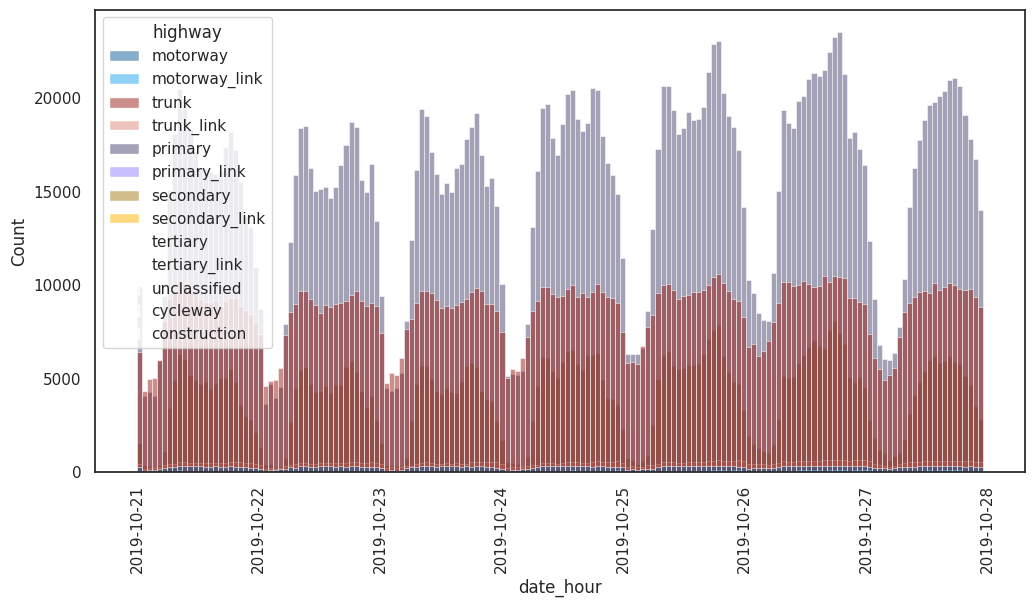

In [18]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style("white")

g = sns.histplot(data = ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
                 x='date_hour', hue="highway", 
                 hue_order= [hw for hw in highway_ordering if simplified_filter(hw)], 
                 palette=osm_color_palette(),
                 bins= 7*24
                 )
plt.xticks(rotation=90)
plt.show()

In [19]:
tspeeds_hourly_count = tspeeds_df.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')
uspeeds_hourly_count = uspeeds_df.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')
matched_hourly_count = ut_merged.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')

In [20]:
tspeeds_hourly_count['label'] = 'mcswts'
uspeeds_hourly_count['label'] = 'uber'
matched_hourly_count['label'] = 'matched'
hourly_count = pd.concat([tspeeds_hourly_count, uspeeds_hourly_count, matched_hourly_count])

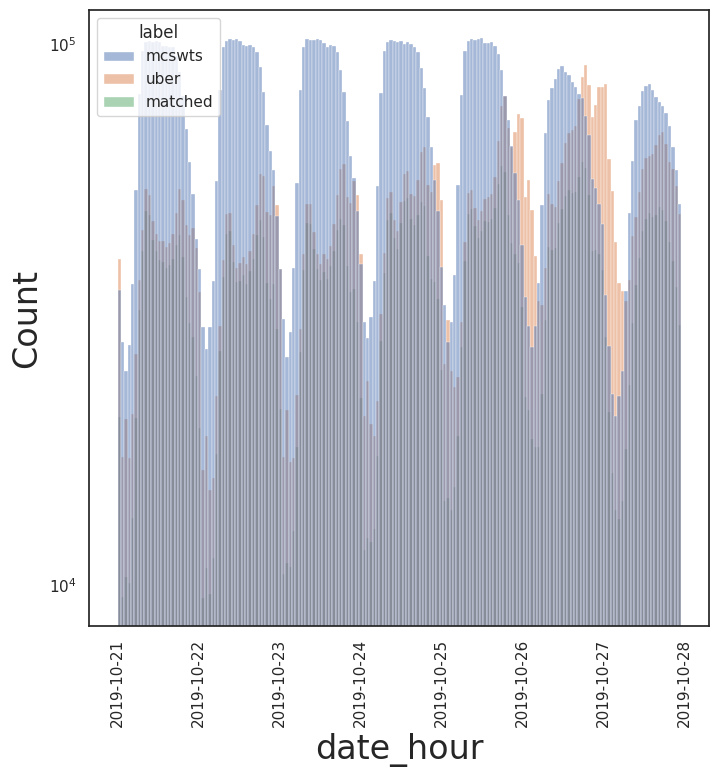

In [21]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("white")
plt.rcParams["axes.labelsize"] = 24

g = sns.histplot(
    hourly_count, x="date_hour", 
    hue="label", 
    log_scale=(False, True),
    bins=24*7
)
plt.xticks(rotation=90)
plt.show()

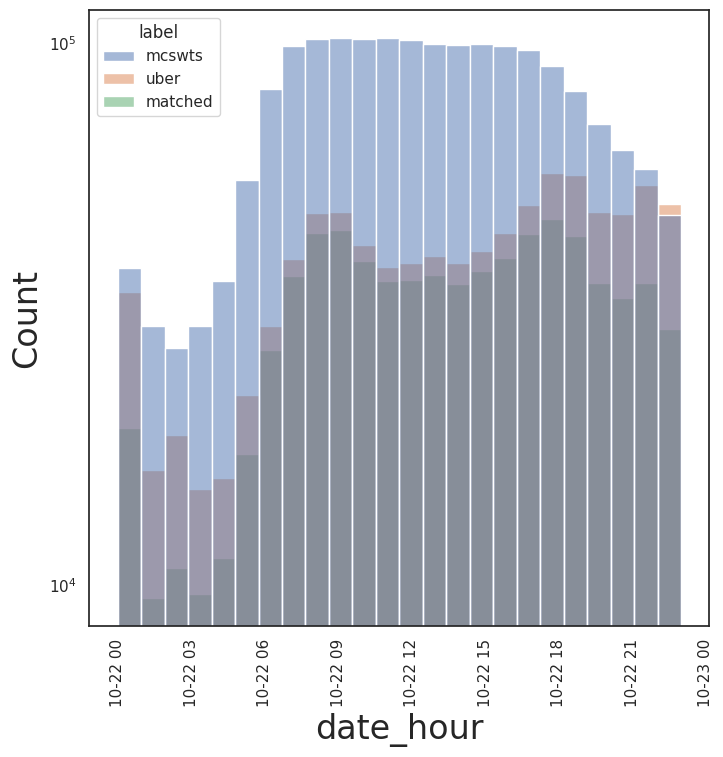

In [22]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("white")
plt.rcParams["axes.labelsize"] = 24

g = sns.histplot(
    hourly_count[(hourly_count['date_hour'] >= datetime(2019, 10, 22)) & 
                (hourly_count['date_hour'] < datetime(2019, 10, 23))], x="date_hour", 
    hue="label", 
    log_scale=(False, True),
    bins=24
)
plt.xticks(rotation=90)
plt.show()

In [23]:
tspeeds_highway_hourly_count = tspeeds_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])
uspeeds_highway_hourly_count = uspeeds_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])
matched_highway_hourly_count = matched_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])

In [24]:
tspeeds_highway_hourly_sum = tspeeds_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in tspeeds_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_43606/442127476.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/442127476.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/442127476.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/442127476.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "coun

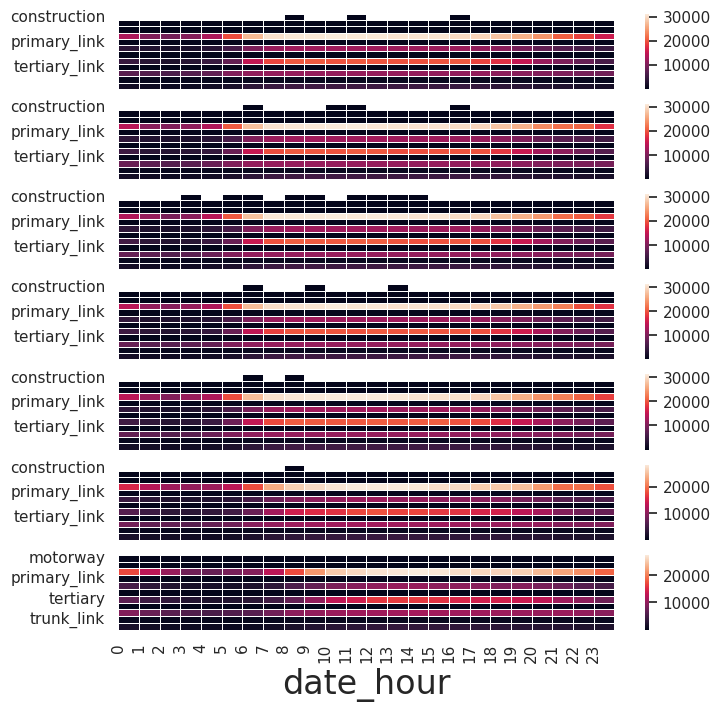

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    tspeeds_highway_hourly_sum_pivot = \
            tspeeds_highway_hourly_sum[(tspeeds_highway_hourly_sum['date_hour'] >= datetime(2019, 10, day)) & 
            (tspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(tspeeds_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

In [26]:
uspeeds_highway_hourly_sum = uspeeds_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in uspeeds_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_43606/295006784.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/295006784.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/295006784.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/295006784.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "coun

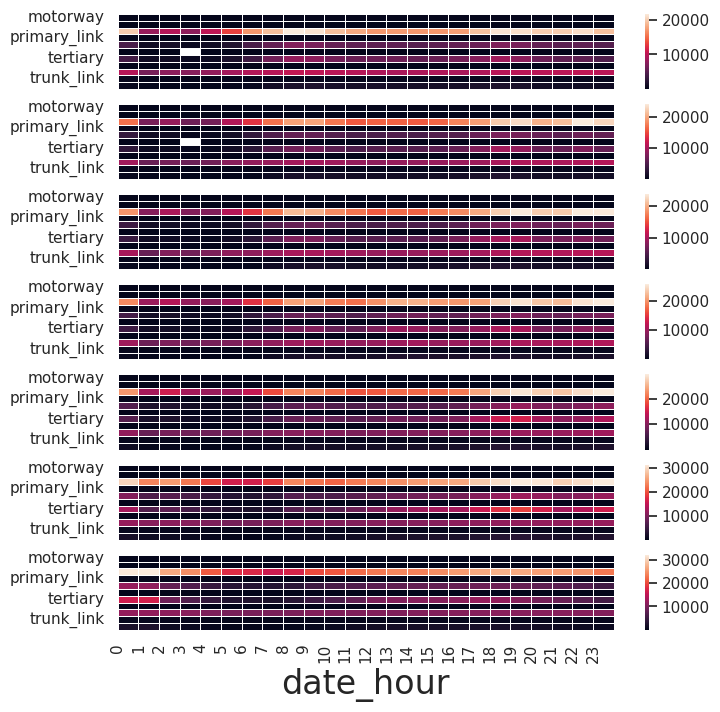

In [27]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    uspeeds_highway_hourly_sum_pivot = \
            uspeeds_highway_hourly_sum[(uspeeds_highway_hourly_sum['date_hour'] >= datetime(2019, 10, day)) & 
            (uspeeds_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(uspeeds_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

In [28]:
matched_highway_hourly_sum = matched_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in matched_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_43606/3749180803.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/3749180803.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/3749180803.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_43606/3749180803.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "

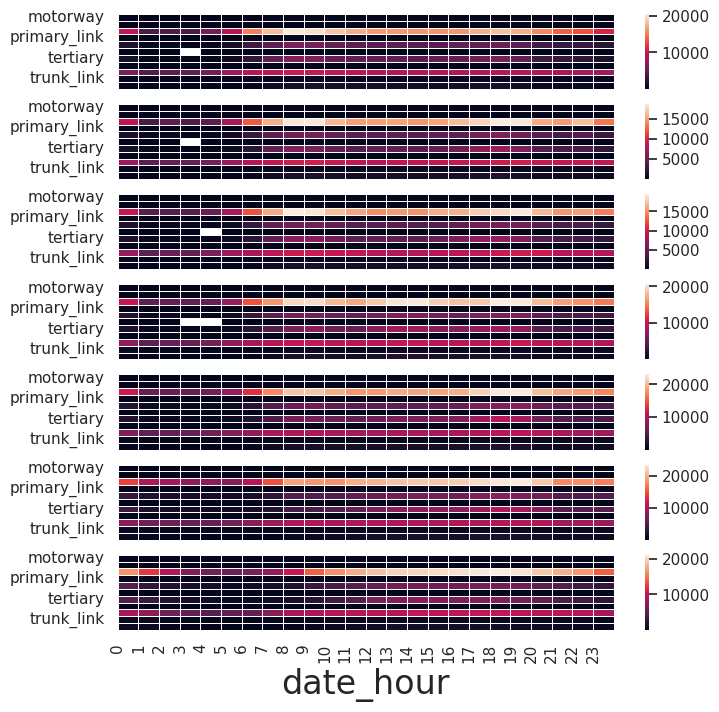

In [29]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    matched_highway_hourly_sum_pivot = \
            matched_highway_hourly_sum[(matched_highway_hourly_sum['date_hour'] >= datetime(2019, 10, day)) & 
            (matched_highway_hourly_sum['date_hour'] < datetime(2019, 10, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(matched_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

# Speed difference analysis

In [30]:
ut_merged['median_uber_diff'] = ut_merged['median_speed_kph'] - ut_merged['speed_kph_mean'] 

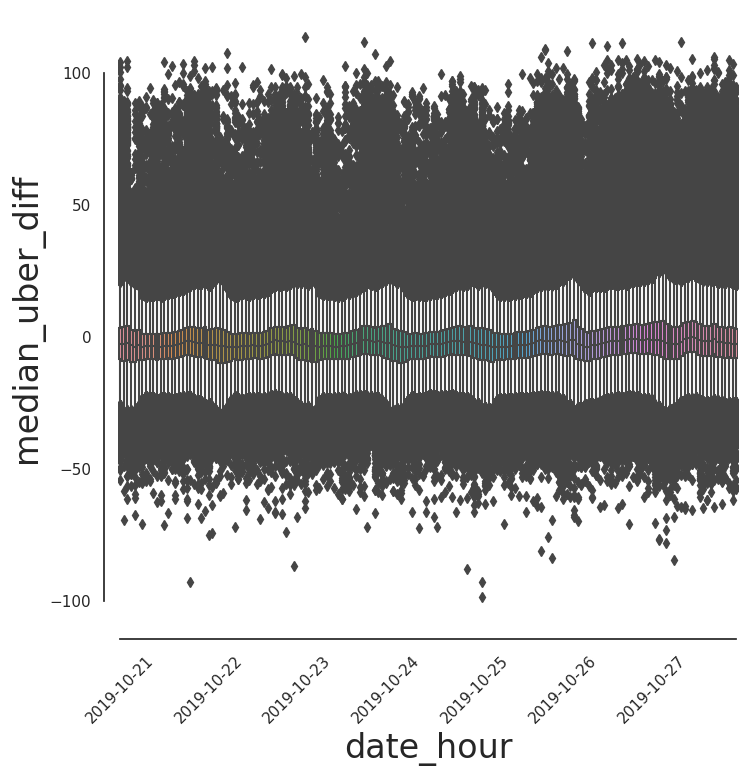

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

g = sns.boxplot(x="date_hour", y="median_uber_diff",
            data=ut_merged, ax = ax)
sns.despine(offset=10, trim=True)

ax.set_xticks(range(0, 24 * 7, 24))
ax.set_xticklabels([f"{YEAR}-{MONTH}-{i}" for i in range(START_DAY, END_DAY + 1)])
plt.xticks(rotation=45)

plt.show()


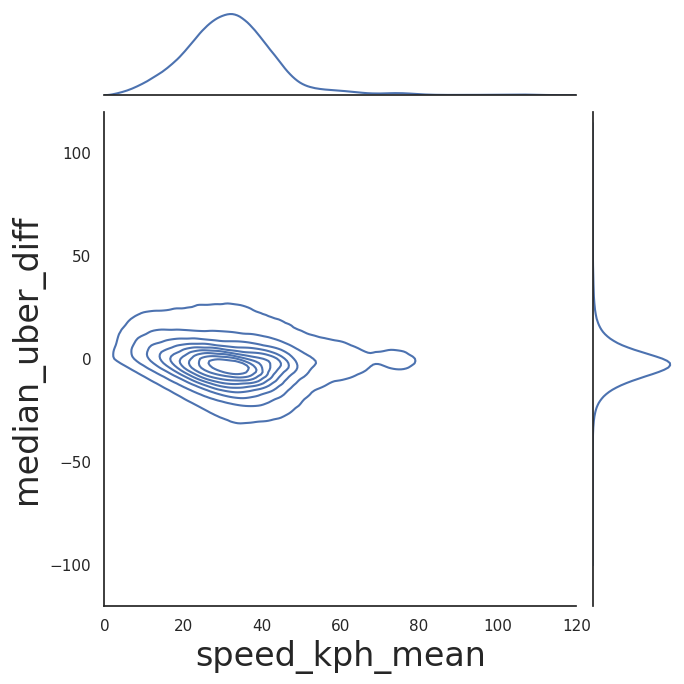

In [32]:
g = sns.jointplot(x="speed_kph_mean", y="median_uber_diff", data=ut_merged,
                  kind="kde", 
                  xlim=(0, 120), ylim=(-120, 120),
                  height=7, 
                  palette=sns.color_palette('Set2'))

## speed difference by time and road types

In [33]:
speed_diff_highway_hourly = ut_merged.groupby(["highway", "hour"])\
            .agg({'median_uber_diff': ['mean', 'count']}).reset_index()
speed_diff_highway_hourly.columns = ["highway", "hour", "speed_diff", "count"]

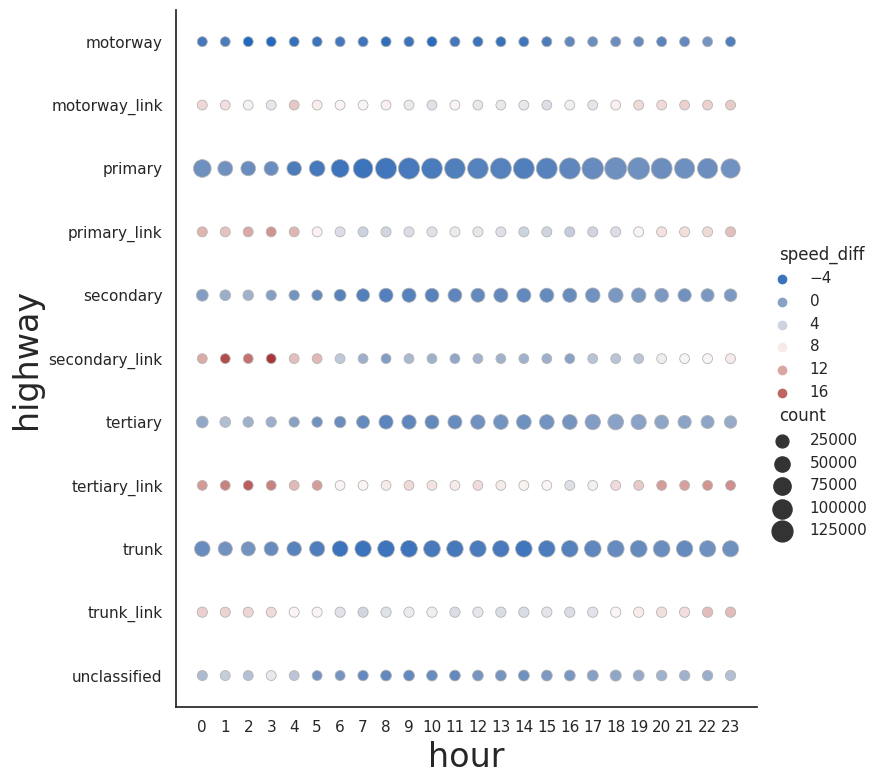

In [34]:
# here the hue refers to the mean of aggreagted speed diff by hour

g = sns.relplot(
    data=speed_diff_highway_hourly[[simplified_filter(hw) for hw in speed_diff_highway_hourly["highway"]]],
    x="hour", y="highway", hue="speed_diff", size="count",
    palette="vlag", edgecolor=".7",
    height=8, sizes=(50, 250), 
)
g.set(xticks= range(24))

## extreme difference by time

In [35]:
ut_merged['median_uber_diff'].quantile(q=0.975), ut_merged['median_uber_diff'].quantile(q=0.025)

(21.64630528200001, -20.619891168875814)

In [36]:
big_pos_div = ut_merged[ut_merged['median_uber_diff'] > ut_merged['median_uber_diff'].quantile(q=0.975)]
big_neg_div = ut_merged[ut_merged['median_uber_diff'] < ut_merged['median_uber_diff'].quantile(q=0.025)]

In [37]:
ut_hourly_matched = ut_merged.groupby('date_hour').size().reset_index(name='count')
big_pos_div_hourly = big_pos_div.groupby('date_hour').size().reset_index(name='count')
big_neg_div_hourly = big_neg_div.groupby('date_hour').size().reset_index(name='count')
hourly_matched = ut_hourly_matched.merge(big_pos_div_hourly, suffixes=["","_pos"], on='date_hour')\
                                    .merge(big_neg_div_hourly, suffixes=["","_neg"], on='date_hour')

In [38]:
hourly_matched['pos_prop'] = hourly_matched['count_pos'] / hourly_matched['count']
hourly_matched['neg_prop'] = hourly_matched['count_neg'] / hourly_matched['count']

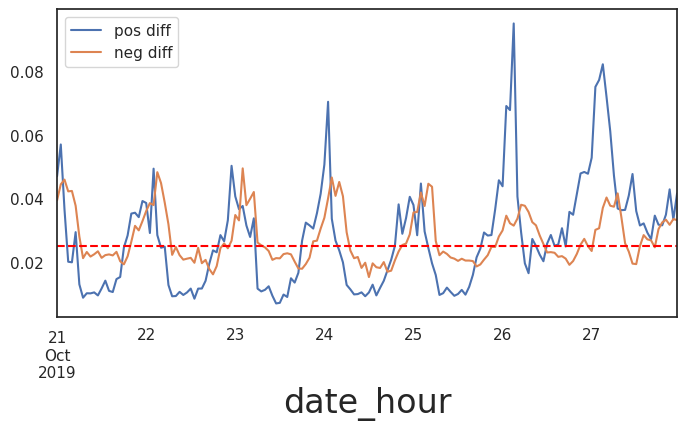

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))

g = hourly_matched.plot(x='date_hour', y="pos_prop", ax=ax, label='pos diff')
g = hourly_matched.plot(x='date_hour', y="neg_prop", ax=ax, label='neg diff')

plt.axhline(0.025, color='red', linestyle='--')
plt.show()

In [40]:
hourly_matched['hour'] = hourly_matched['date_hour'].dt.hour

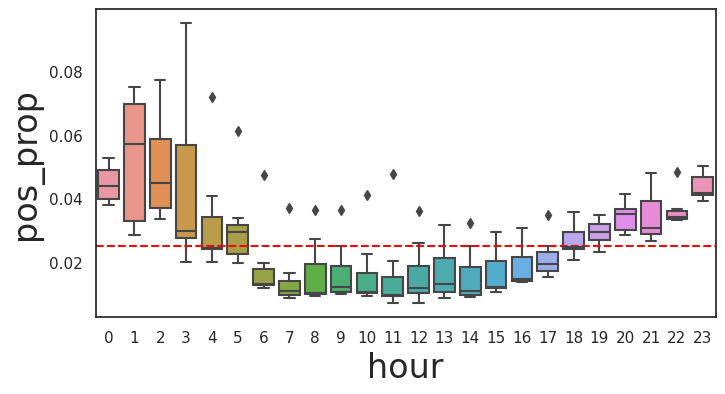

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.boxplot(hourly_matched, x= 'hour', y="pos_prop", ax=ax)

plt.axhline(0.025, color='red', linestyle='--')
plt.show()

Are there segments always having big speed difference?

In [42]:
pos_seg_counts = big_pos_div.groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()
neg_seg_counts = big_neg_div.groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()

In [43]:
pos_seg_counts['date_hour'].describe()

count    50642.000000
mean         2.941748
std          6.253759
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        134.000000
Name: date_hour, dtype: float64

In [44]:
neg_seg_counts['date_hour'].describe()

count    40313.000000
mean         3.695483
std          7.537266
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        157.000000
Name: date_hour, dtype: float64

In [45]:
pos_seg_counts = pos_seg_counts.sort_values("date_hour", ascending=False)
neg_seg_counts = neg_seg_counts.sort_values("date_hour", ascending=False)

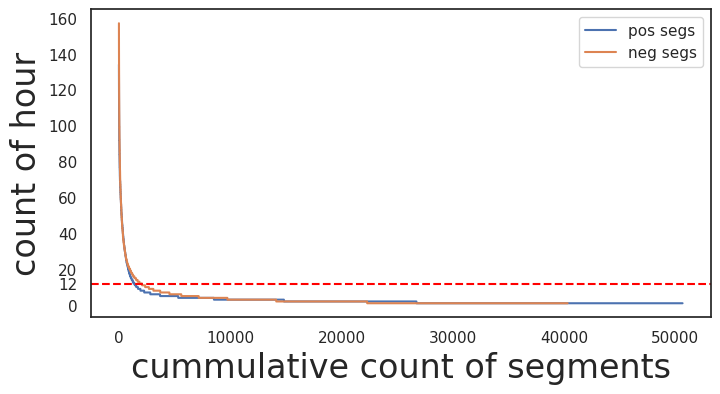

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))

g = ax.plot(range(pos_seg_counts.shape[0]), pos_seg_counts.date_hour, label='pos segs')
g = ax.plot(range(neg_seg_counts.shape[0]), neg_seg_counts.date_hour, label='neg segs')
ax.set_ylabel('count of hour')
ax.set_xlabel('cummulative count of segments')

ax.set_yticks(list(range(0, 170, 20)) + [12])

plt.axhline(12, color='red', linestyle='--')
plt.legend()
plt.show()

In [47]:
pos_seg_counts.sort_values("date_hour", ascending=False)

,u,v,gkey,date_hour
28806,474729666,1489009750,474729666_1489009750_39601701,134
34414,1452874239,2518801009,1452874239_2518801009_244577576,128
40145,2252623868,419139314,2252623868_419139314_226690148,128
33993,1409863554,1409863549,1409863554_1409863549_131958374,127
41403,2535765365,2143397507,2535765365_2143397507_246549732,126
...,...,...,...,...
12402,25894157,25893968,25894157_25893968_210324553,1
12377,25879185,25885235,25879185_25885235_4311306,1
12373,25879004,25879139,25879004_25879139_4247639,1
12367,25878794,195713,25878794_195713_4252418,1


In [48]:
# worst case 

s_u, s_v, s_gkey, s_dh = pos_seg_counts.sort_values("date_hour", ascending=False).iloc[0]

sample_big_pos_div = ut_merged[(ut_merged['u'] == s_u) & (ut_merged['v'] == s_v) 
            & (ut_merged['gkey'] == s_gkey)] 

s_seg = gdf_edges[(gdf_edges['u'] == s_u) & (gdf_edges['v'] == s_v) 
            & (gdf_edges['gkey'] == s_gkey)]

In [49]:
s_map = folium.Map(location = (s_seg['geometry'].centroid.y, 
                                s_seg['geometry'].centroid.x), zoom_start = 16)
s_j = s_seg['geometry'].to_json()
s_j = folium.GeoJson(data=s_j, style_function=lambda x: {'color': 'red'})
s_j.add_to(s_map)

s_map

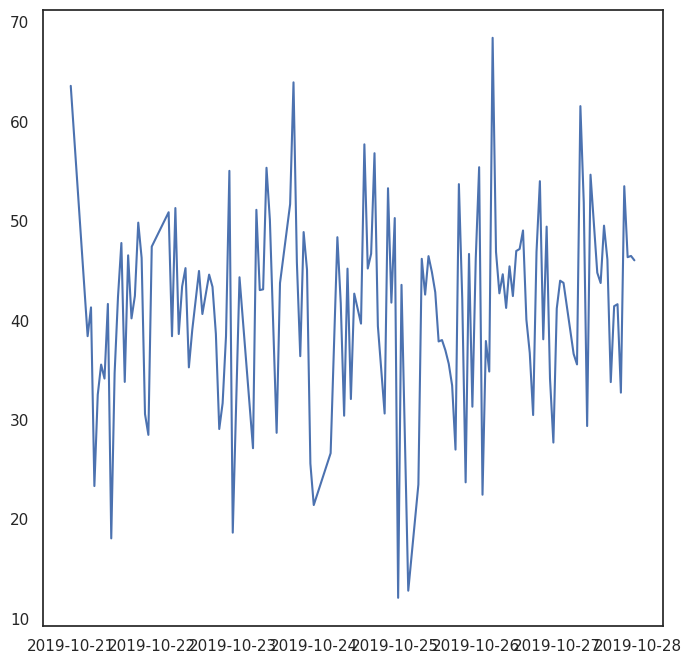

In [50]:
plt.plot(sample_big_pos_div["date_hour"], sample_big_pos_div["median_uber_diff"])

In [51]:
# worst case 

s_u, s_v, s_gkey, s_dh = neg_seg_counts.sort_values("date_hour", ascending=False).iloc[0]

sample_big_neg_div = ut_merged[(ut_merged['u'] == s_u) & (ut_merged['v'] == s_v) 
            & (ut_merged['gkey'] == s_gkey)] 

s_seg = gdf_edges[(gdf_edges['u'] == s_u) & (gdf_edges['v'] == s_v) 
            & (gdf_edges['gkey'] == s_gkey)]

In [52]:
s_map = folium.Map(location = (s_seg['geometry'].centroid.y, 
                                s_seg['geometry'].centroid.x), zoom_start = 16)
s_j = s_seg['geometry'].to_json()
s_j = folium.GeoJson(data=s_j, style_function=lambda x: {'color': 'red'})
s_j.add_to(s_map)
s_map

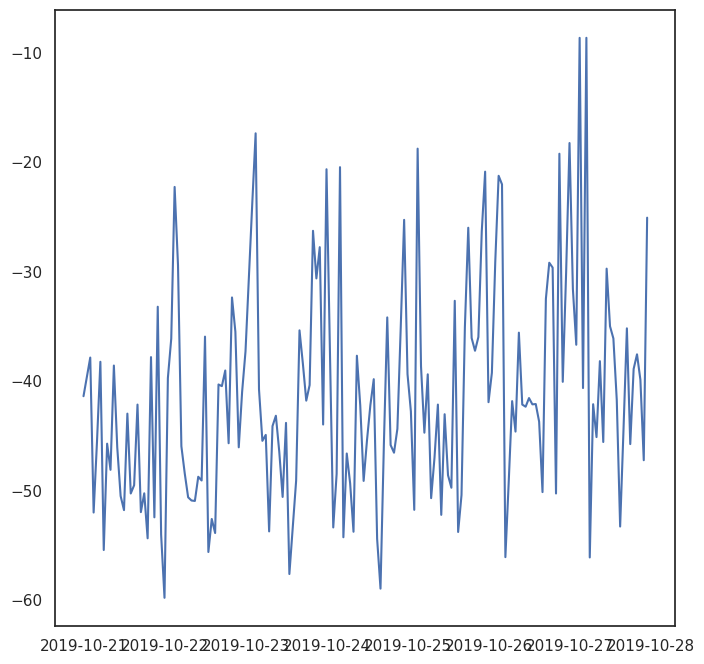

In [53]:
plt.plot(sample_big_neg_div["date_hour"], sample_big_neg_div["median_uber_diff"])

In [54]:
pos_seg_counts[pos_seg_counts["date_hour"] > 12].shape, neg_seg_counts[neg_seg_counts["date_hour"] > 12].shape

((1298, 4), (1839, 4))

In [55]:
pos_neg_seg_counts = pos_seg_counts.merge(neg_seg_counts, on=["u", "v", "gkey"], how='inner', suffixes=["_pos","_neg"])
print(pos_neg_seg_counts.shape, pos_seg_counts.shape, neg_seg_counts.shape)

(23299, 5) (50642, 4) (40313, 4)


In [56]:
pos_neg_seg_counts.to_csv('speed_diff_ext_pos_neg_seg.csv')

In [57]:
# no case with consistant big negative and positive values

pos_neg_seg_counts[(pos_neg_seg_counts["date_hour_pos"] > 12) & (pos_neg_seg_counts["date_hour_neg"]) > 12].shape

(0, 5)

In [58]:
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        < pos_neg_seg_counts['date_hour_neg']]['date_hour_pos']
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        >= pos_neg_seg_counts['date_hour_neg']]['date_hour_neg']

In [59]:
pos_neg_seg_counts['overlap_hour'].max()

18.0

In [60]:
seg_highway_counts = gdf_edges.groupby('highway').size().reset_index(name='count')

In [61]:
seg_highway_counts

,highway,count
0,construction,1
1,living_street,53
2,motorway,311
3,motorway_link,125
4,primary,33917
5,primary_link,511
6,residential,37277
7,road,2
8,secondary,14738
9,secondary_link,88


In [62]:
# It is # of segments
pos_seg_highway_counts = pos_seg_counts.merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')

In [63]:
pos_seg_highway_counts = pos_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
pos_seg_highway_counts['prop'] = pos_seg_highway_counts['count_pos'] / pos_seg_highway_counts['count_all']

In [64]:
neg_seg_highway_counts = neg_seg_counts.merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')

In [65]:
neg_seg_highway_counts = neg_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
neg_seg_highway_counts['prop'] = neg_seg_highway_counts['count_pos'] / neg_seg_highway_counts['count_all']

In [66]:
pos_seg_highway_counts['label'] = 'pos'
neg_seg_highway_counts['label'] = 'neg'

In [67]:
pos_neg_highway = pd.concat([pos_seg_highway_counts, neg_seg_highway_counts], axis=0)

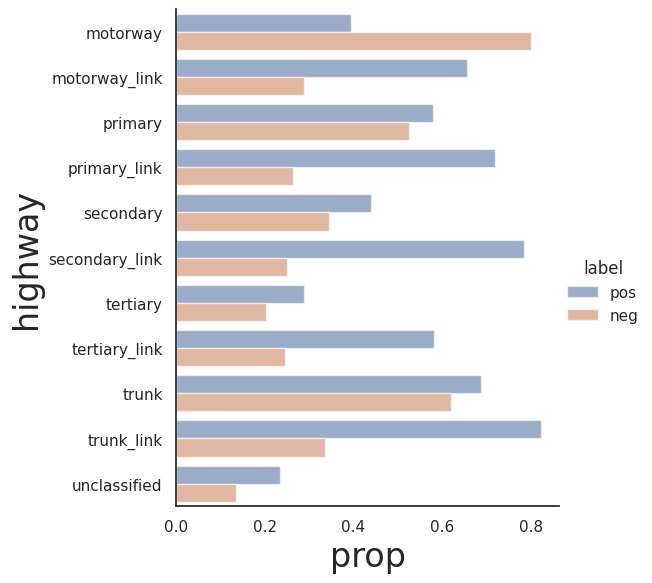

In [68]:
g = sns.catplot(
    data= pos_neg_highway[[simplified_filter(hw) for hw 
                            in pos_neg_highway["highway"]]], 
    kind="bar",
    x="prop", y="highway", hue="label",
    # alette="dark", 
    alpha=.6, height=6
)

In [69]:
# stats of segs with hour > 12
pos_seg_highway_counts = pos_seg_counts[pos_seg_counts['date_hour'] > 12].merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')
pos_seg_highway_counts = pos_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
pos_seg_highway_counts['prop'] = pos_seg_highway_counts['count_pos'] / pos_seg_highway_counts['count_all']

neg_seg_highway_counts = neg_seg_counts[neg_seg_counts['date_hour'] > 12].merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')
neg_seg_highway_counts = neg_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
neg_seg_highway_counts['prop'] = neg_seg_highway_counts['count_pos'] / neg_seg_highway_counts['count_all']

pos_seg_highway_counts['label'] = 'pos'
neg_seg_highway_counts['label'] = 'neg'

pos_neg_highway = pd.concat([pos_seg_highway_counts, neg_seg_highway_counts], axis=0)

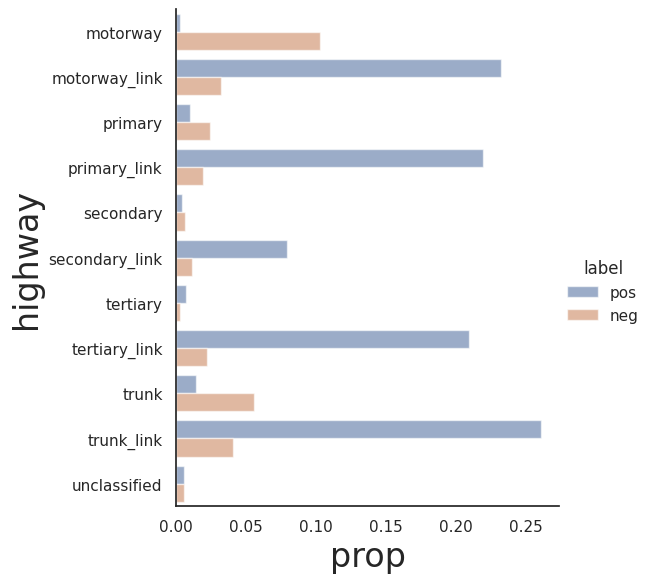

In [70]:
g = sns.catplot(
    data= pos_neg_highway[[simplified_filter(hw) for hw 
                            in pos_neg_highway["highway"]]], 
    kind="bar",
    x="prop", y="highway", hue="label",
    # alette="dark", 
    alpha=.6, height=6
)

Are there segments always having big speed difference within day-time?

In [71]:
DAYTIME_START_HOUR=8
DAYTIME_END_HOUR=18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [72]:
pos_seg_counts = big_pos_div[(big_pos_div.hour >= DAYTIME_START_HOUR) & (big_pos_div.hour < DAYTIME_END_HOUR)]\
                        .groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()
neg_seg_counts = big_neg_div[(big_neg_div.hour >= DAYTIME_START_HOUR) & (big_neg_div.hour < DAYTIME_END_HOUR)]\
                        .groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()

In [73]:
pos_seg_counts['date_hour'].describe()

count    27369.000000
mean         1.937265
std          3.380931
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         68.000000
Name: date_hour, dtype: float64

In [74]:
neg_seg_counts['date_hour'].describe()

count    25386.000000
mean         2.703656
std          4.783011
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         70.000000
Name: date_hour, dtype: float64

In [75]:
pos_seg_counts = pos_seg_counts.sort_values("date_hour", ascending=False)
neg_seg_counts = neg_seg_counts.sort_values("date_hour", ascending=False)

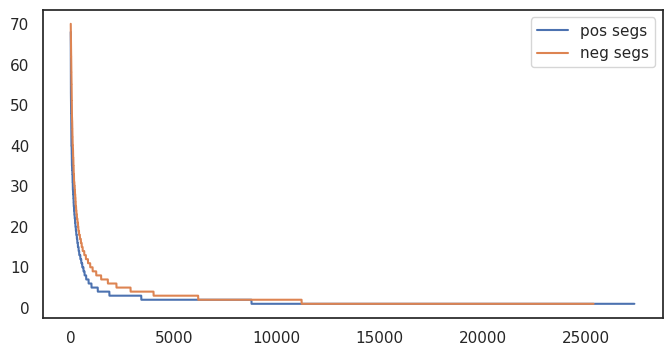

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))

g = ax.plot(range(pos_seg_counts.shape[0]), pos_seg_counts.date_hour, label='pos segs')
g = ax.plot(range(neg_seg_counts.shape[0]), neg_seg_counts.date_hour, label='neg segs')
plt.legend()
plt.show()

In [77]:
print(pos_seg_counts[pos_seg_counts["date_hour"] > DAYTIME_HOURS].shape, 
neg_seg_counts[neg_seg_counts["date_hour"] > DAYTIME_HOURS].shape)

(556, 4) (943, 4)


In [78]:
pos_neg_seg_counts = pos_seg_counts.merge(neg_seg_counts, on=["u", "v", "gkey"], how='inner', suffixes=["_pos","_neg"])
print(pos_neg_seg_counts.shape, pos_seg_counts.shape, neg_seg_counts.shape)

(7538, 5) (27369, 4) (25386, 4)


In [79]:
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        <= pos_neg_seg_counts['date_hour_neg']]['date_hour_pos']
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        > pos_neg_seg_counts['date_hour_neg']]['date_hour_neg']

In [80]:
pos_neg_seg_counts['overlap_hour'].max()

6.0

In [81]:
pos_neg_seg_counts.sort_values('overlap_hour', ascending = False)

,u,v,gkey,date_hour_pos,date_hour_neg,overlap_hour
34,1639062993,310961,1639062993_310961_516501336,7,6,6.0
1,198718,367004385,198718_367004385_605387698,20,5,5.0
44,25572352,25572349,25572352_25572349_103917336,6,5,5.0
23,367004385,448875268,367004385_448875268_605387696,11,5,5.0
28,2518585800,1203361421,2518585800_1203361421_244551102,9,4,4.0
...,...,...,...,...,...,...
7533,101310285,4328306216,101310285_4328306216_617248744,1,2,NaN
7534,101306762,271049923,101306762_271049923_100791660,1,1,NaN
7535,100429283,32858332,100429283_32858332_535863172,1,1,NaN
7536,98210188,13823671,98210188_13823671_651852808,1,1,NaN


In [82]:
pos_neg_seg_counts.to_csv('speed_diff_ext_pos_neg_seg_daytime.csv')